<a href="https://colab.research.google.com/github/riyaaaarane/reddit-analysis/blob/main/reddit_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
import re
import pandas as pd
nlp = spacy.load("en_core_web_sm")

In [ ]:
df = pd.read_csv('/content/work_culture_companies.csv')

In [ ]:
df.head()

Company                                              Title  \
0  Facebook  Facebook needs to be investigated. They priori...   
1  Facebook  Am I wrong? Deleted both Facebook and instagra...   
2  Facebook  DISABLED ACCOUNT IN FB (FOR NO ABSOLUTELY NO R...   
3  Facebook  Apparently facebook is insinuating you are a p...   
4  Facebook  Good as they should! you can't just falsely ac...   

                                           Post Text       ID  Score  \
0  Lately, I’ve been noticing that Facebook’s alg...  1m0q6zl    512   
1  So I permanently deleted my Facebook and insta...  1ma8ux1    331   
2  AM I THE ONLY ONE WHO IS EXPERIENCING THIS? PL...  1mmmwa7    386   
3                                                NaN  1m9cn2i    295   
4                                                NaN  1mcifjc    277   

   Total Comments                                           Post URL  
0             356  https://www.reddit.com/r/facebook/comments/1m0...  
1             160  https://www.reddit.com/r/facebook/comments/1ma...  
2             689               https://i.redd.it/uh60cibmx7if1.jpeg  
3             108               https://i.redd.it/4sgtfmaqh3ff1.jpeg  
4              61               https://i.redd.it/b7v7tfo2quff1.jpeg

In [ ]:
df.shape

(391, 7)

In [ ]:
df.drop(['ID', 'Score', 'Post URL'], axis=1, inplace=True)

In [ ]:
import string

#text cleaning
def clean_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')  # Fix encoding issues
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W+', ' ', text)  # Remove special characters, keep spaces
    return text.strip()

# Clean both Title and Post Text
df['cleaned_title'] = df['Title'].apply(clean_text)
df['cleaned_post'] = df['Post Text'].apply(clean_text)

print(df[['cleaned_title', 'cleaned_post']].head())

                                       cleaned_title  \
0  facebook needs to be investigated they priorit...   
1  am i wrong deleted both facebook and instagram...   
2  disabled account in fb for no absolutely no re...   
3  apparently facebook is insinuating you are a p...   
4  good as they should you cant just falsely accu...   

                                        cleaned_post  
0  lately ive been noticing that facebooks algori...  
1  so i permanently deleted my facebook and insta...  
2  am i the only one who is experiencing this pls...  
3                                                     
4                                                     


In [ ]:
# Merge cleaned title and post into a single column
df['combined_text'] = df['cleaned_title'] + " " + df['cleaned_post']

In [ ]:
def lemmatize_no_stopwords(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Apply on combined column
df['lemmas'] = df['combined_text'].apply(lemmatize_no_stopwords)


In [ ]:
df.isna().sum()

Company             0
Title               0
Post Text         171
Total Comments      0
cleaned_title       0
cleaned_post        0
title_lemmas        0
post_lemmas         0
combined_text       0
lemmas              0
dtype: int64

In [ ]:
df.drop(['Total Comments', 'post_lemmas', 'title_lemmas','Post Text','Title'], inplace=True , axis=1)

In [ ]:
df.isna().sum()

Company          0
cleaned_title    0
cleaned_post     0
combined_text    0
lemmas           0
dtype: int64

# BAG OF WORDS

In [ ]:
from collections import Counter

# Dictionary to store word frequencies per company
company_word_freqs = {}

for company, group in df.groupby("Company"):
    all_words = [word for lemmas in group["lemmas"] for word in lemmas]
    freq = Counter(all_words)

    # Convert to DataFrame
    word_freq_df = pd.DataFrame(freq.items(), columns=["Word", "Frequency"])
    word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

    company_word_freqs[company] = word_freq_df

# Example: Show Facebook’s top 10 words
print(company_word_freqs["Tesla"].head(10))

           Word  Frequency
0         tesla         18
1         model         12
2           new          9
3             y          9
4  supercharger          7
5         diner          6
6          open          4
7          dojo          4
8          long          4
9           fsd          4


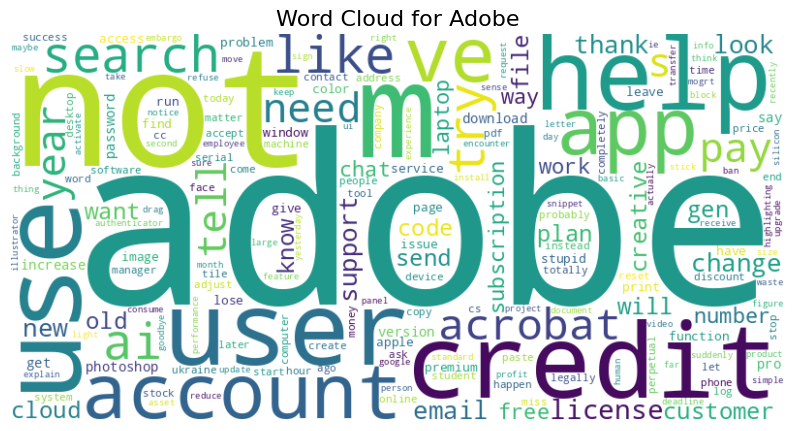

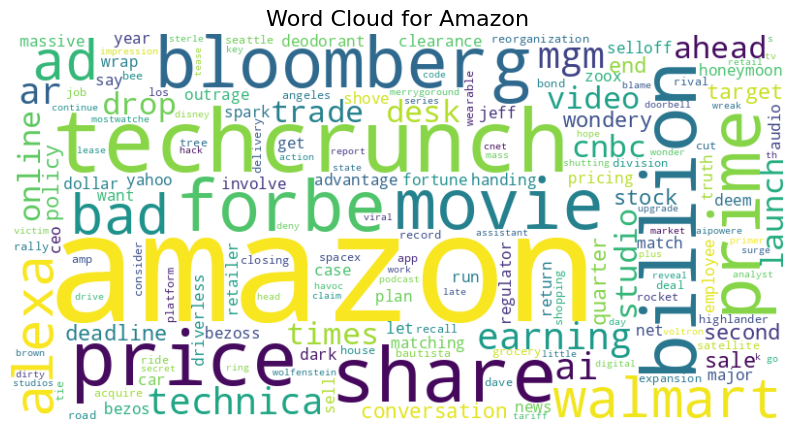

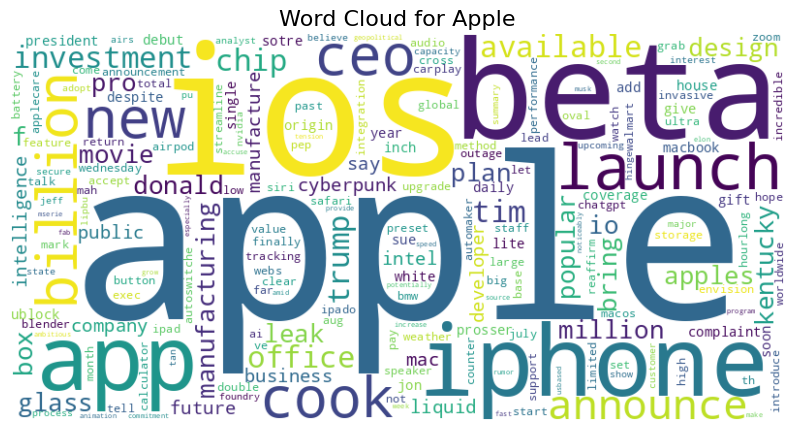

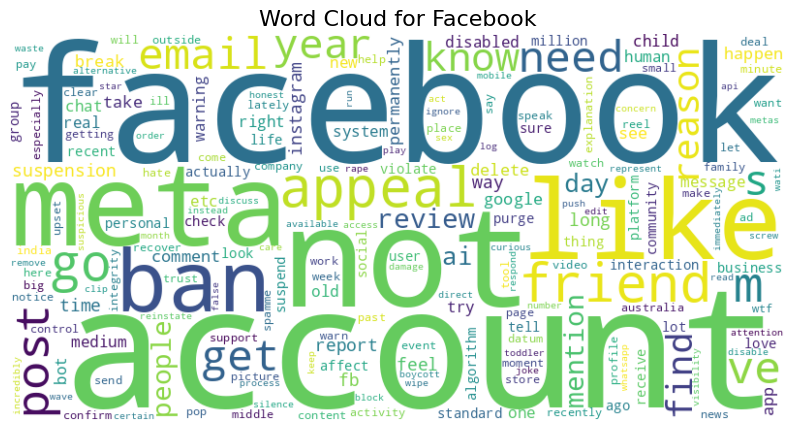

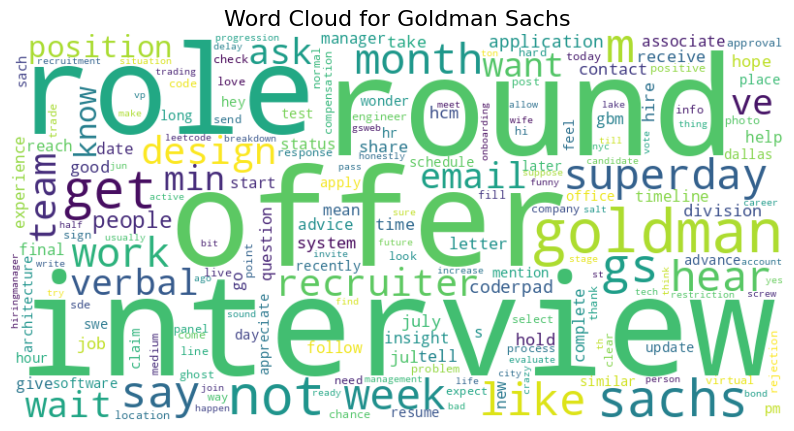

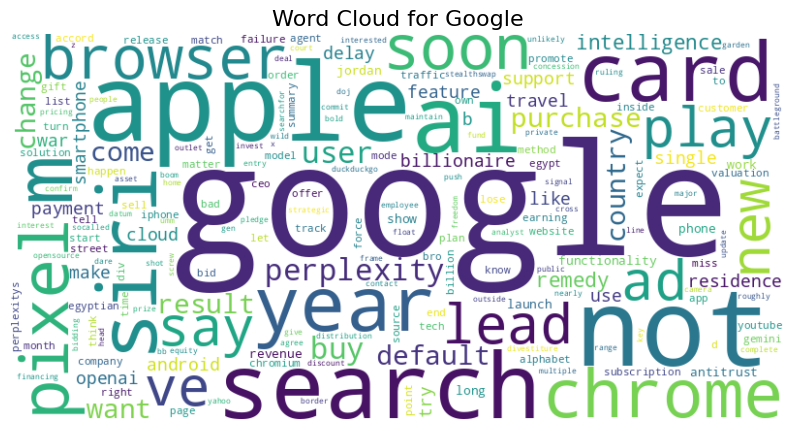

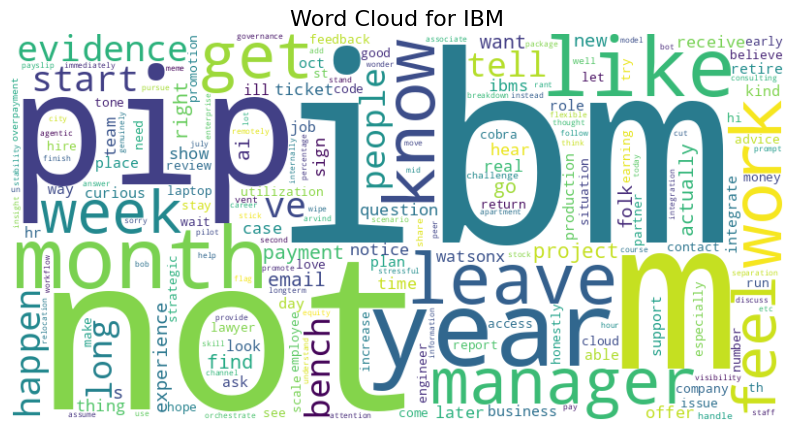

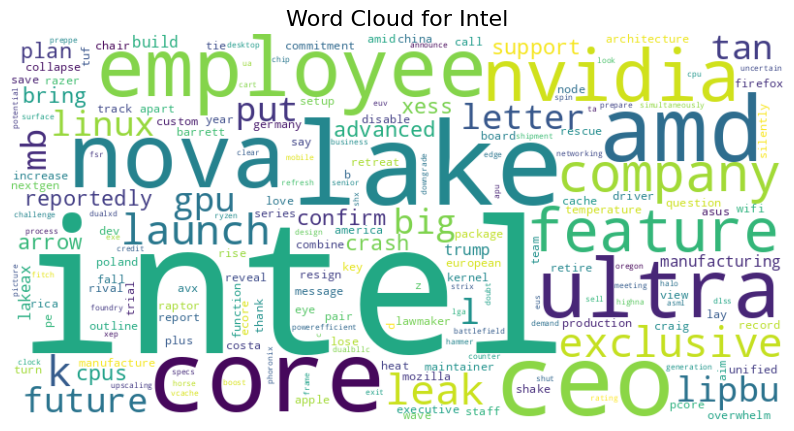

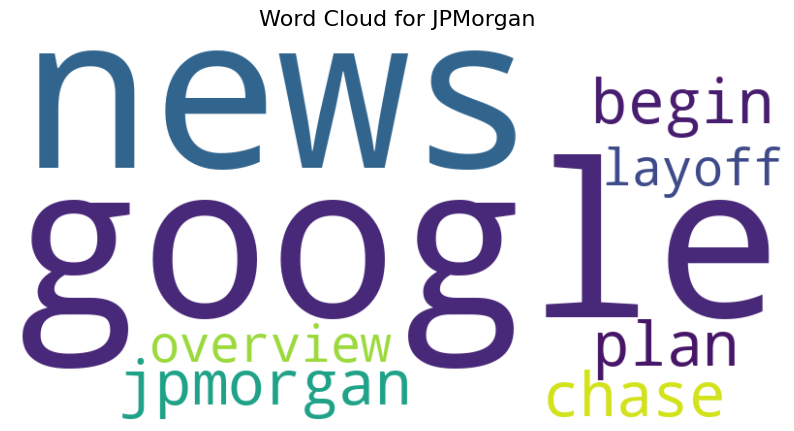

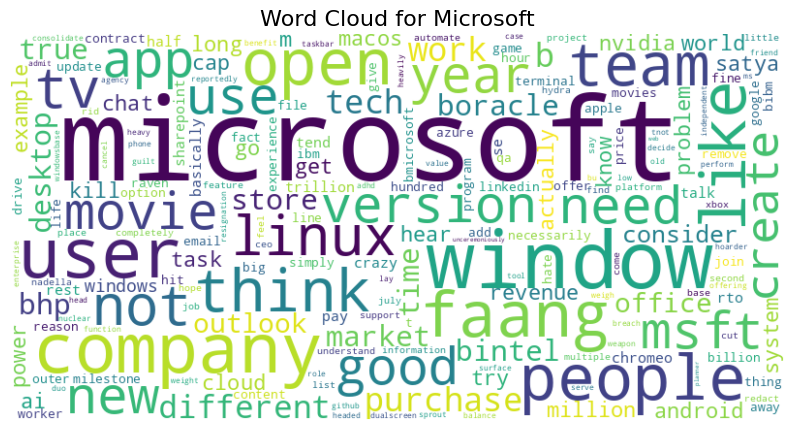

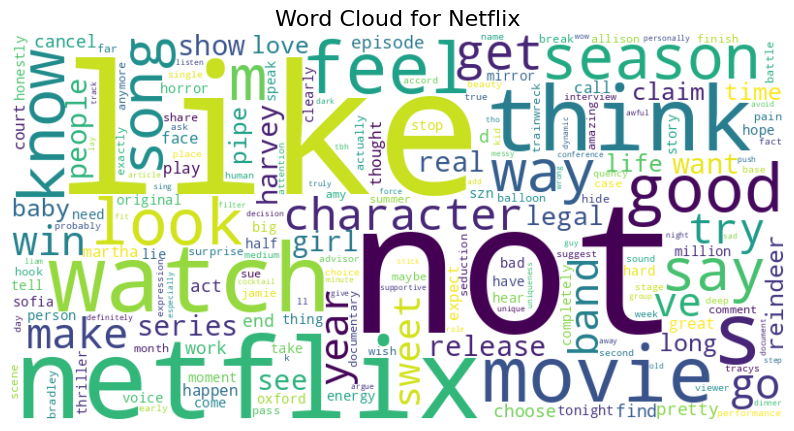

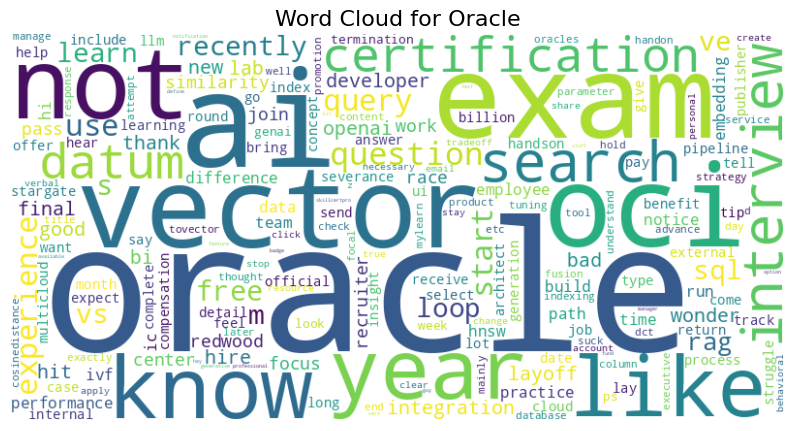

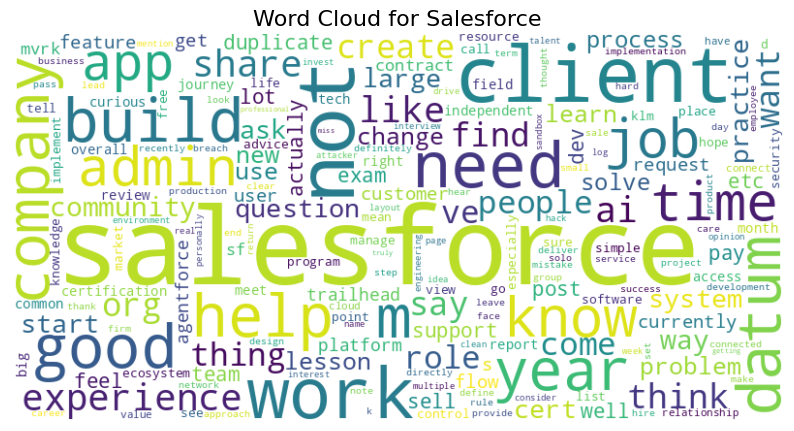

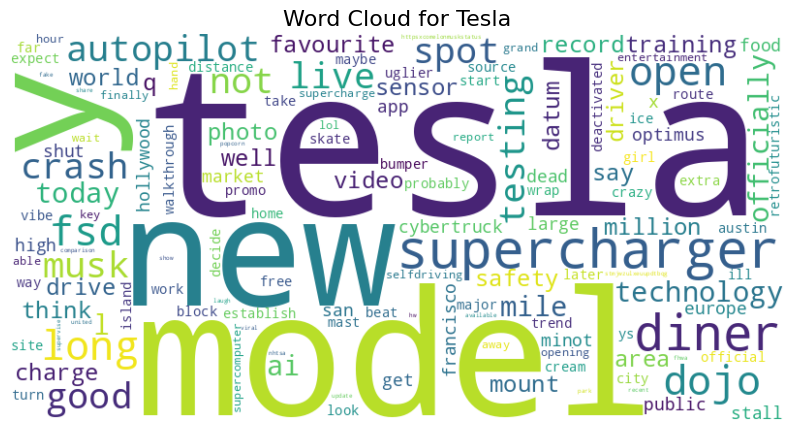

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Loop through each company
for company, word_freq_df in company_word_freqs.items():
    # Convert to dictionary (WordCloud expects dict {word: freq})
    freq_dict = dict(zip(word_freq_df["Word"], word_freq_df["Frequency"]))

    # Generate wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {company}", fontsize=16)
    plt.show()


# TFIDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join lemmas back into string form (since TF-IDF expects text, not tokens)
df["lemmas_str"] = df["lemmas"].apply(lambda x: " ".join(x))

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # keep top 1000 features
X = tfidf.fit_transform(df["lemmas_str"])

# Create dataframe of TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out(), index=df["Company"])

print(tfidf_df.tail())


            able  absolutely  accept  access  accord  account  acrobat  act  \
Company                                                                       
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   

            action  activate  ...      work  world  worth  write  wrong  wtf  \
Company                       ...                                              
Salesforce     0.0       0.0  ...  0.108819    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000   

In [41]:
tfidf_df.index = df.index

# Group by company and take mean
company_tfidf = tfidf_df.groupby(df["Company"]).mean()

# Now company names will be index
print(company_tfidf.index.tolist())

['Adobe', 'Amazon', 'Apple', 'Facebook', 'Goldman Sachs', 'Google', 'IBM', 'Intel', 'JPMorgan', 'Microsoft', 'Netflix', 'Oracle', 'Salesforce', 'Tesla']


In [45]:
# Top 10 words for Salesforce
salesforce_top = company_tfidf.loc["Salesforce"].sort_values(ascending=False).head(15)
print(salesforce_top)

salesforce    0.181552
admin         0.056010
datum         0.054148
not           0.053012
work          0.051565
flow          0.046014
cert          0.044313
app           0.043400
agentforce    0.043248
org           0.040917
ai            0.038548
know          0.038129
think         0.037598
company       0.036905
experience    0.035633
Name: Salesforce, dtype: float64


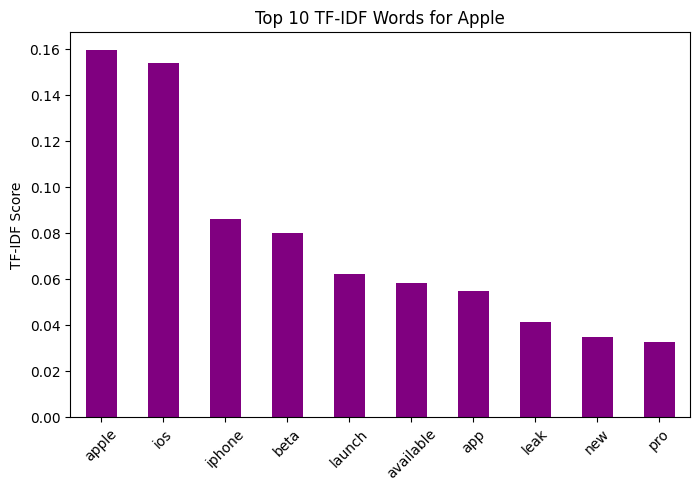

In [44]:
company = "Apple"
top_words = company_tfidf.loc[company].sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_words.plot(kind="bar", color="purple")
plt.title(f"Top 10 TF-IDF Words for {company}")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=45)
plt.show()


In [46]:
top_words_per_company = {}

for company in company_tfidf.index:
    top_words = company_tfidf.loc[company].sort_values(ascending=False).head(5).index.tolist()
    top_words_per_company[company] = top_words

print(top_words_per_company)

{'Adobe': ['adobe', 'not', 'photoshop', 'use', 'acrobat'], 'Amazon': ['amazon', 'techcrunch', 'ar', 'bloomberg', 'forbe'], 'Apple': ['apple', 'ios', 'iphone', 'beta', 'launch'], 'Facebook': ['facebook', 'account', 'ban', 'meta', 'like'], 'Goldman Sachs': ['interview', 'round', 'offer', 'goldman', 'role'], 'Google': ['google', 'search', 'earning', 'card', 'ai'], 'IBM': ['ibm', 'bench', 'discuss', 'not', 'know'], 'Intel': ['intel', 'lake', 'ceo', 'amd', 'nova'], 'JPMorgan': ['layoff', 'news', 'plan', 'google', 'pop'], 'Microsoft': ['microsoft', 'window', 'kill', 'true', 'tv'], 'Netflix': ['netflix', 'like', 'watch', 'season', 'not'], 'Oracle': ['oracle', 'oci', 'year', 'layoff', 'ai'], 'Salesforce': ['salesforce', 'admin', 'datum', 'not', 'work'], 'Tesla': ['tesla', 'model', 'supercharger', 'new', 'diner']}


In [ ]:
df.head()

Company                                              Title  \
0  Facebook  Facebook needs to be investigated. They priori...   
1  Facebook  Am I wrong? Deleted both Facebook and instagra...   
2  Facebook  DISABLED ACCOUNT IN FB (FOR NO ABSOLUTELY NO R...   
3  Facebook  Apparently facebook is insinuating you are a p...   
4  Facebook  Good as they should! you can't just falsely ac...   

                                           Post Text       ID  Score  \
0  Lately, I’ve been noticing that Facebook’s alg...  1m0q6zl    512   
1  So I permanently deleted my Facebook and insta...  1ma8ux1    331   
2  AM I THE ONLY ONE WHO IS EXPERIENCING THIS? PL...  1mmmwa7    386   
3                                                NaN  1m9cn2i    295   
4                                                NaN  1mcifjc    277   

   Total Comments                                           Post URL  \
0             356  https://www.reddit.com/r/facebook/comments/1m0...   
1             160  https://www.reddit.com/r/facebook/comments/1ma...   
2             689               https://i.redd.it/uh60cibmx7if1.jpeg   
3             108               https://i.redd.it/4sgtfmaqh3ff1.jpeg   
4              61               https://i.redd.it/b7v7tfo2quff1.jpeg   

                                normalized_post_text  \
0  lately notice facebook algorithm promote prior...   
1  permanently delete facebook instagram constant...   
2  experience pls comment u share exp account lit...   
3                                                      
4                                                      

                                    normalized_title  
0  facebook need investigate prioritize hate spee...  
1        wrong delete facebook instagram permanently  
2     disabled account fb absolutely reason warnings  
3  apparently facebook insinuate peadophile like ...  
4  good falsely accuse people disrupt life busine...

In [ ]:
df = df.drop(['ID', 'Post URL', 'Total Comments', 'Score'], axis=1)

In [ ]:
df = df.drop(['Post Text', 'Title'], axis=1)

In [ ]:
df

Company                               normalized_post_text  \
0      Facebook  lately notice facebook algorithm promote prior...   
1      Facebook  permanently delete facebook instagram constant...   
2      Facebook  experience pls comment u share exp account lit...   
3      Facebook                                                      
4      Facebook                                                      
..          ...                                                ...   
386  Salesforce  consultant target util company time count util...   
387  Salesforce                             app tool document flow   
388  Salesforce  tech support software company chicagoland curr...   
389  Salesforce  hi trailblazers mainly fellow solo admin small...   
390  Salesforce  org start work 400 custom field object need fi...   

                                      normalized_title  
0    facebook need investigate prioritize hate spee...  
1          wrong delete facebook instagram permanently  
2       disabled account fb absolutely reason warnings  
3    apparently facebook insinuate peadophile like ...  
4    good falsely accuse people disrupt life busine...  
..                                                 ...  
386           individual utilization rates consultants  
387                             app tool document flow  
388                   accidental admin salary increase  
389                                  change production  
390                             eliminate unused field  

[391 rows x 3 columns]